# Comparisons

- In this notebook, we compare our algorithm---*PE-UCRL*---to ablations and SOTA.
- To rerun the experiments, run ```python3 train.py reset_and_deadlock``` in the terminal (from ```PilotExperimentation/```), preferably in a detached terminal window.
    - Note that the seeds are randomly generated. For deterministic seeds, make alterations to ```configs/reset_and_deadlock.py```.
    - The run will use a maximum of 9 cores.
- To get the plots, run ```for i in {0..41}; do python3 eval.py reset_and_deadlock/$i --rmax 1; done``` in the terminal.

## Environments
- There are two environments: *Reset* and *Deadlock*.
  - Both of them can be interpreted as models of polarisation in recommender engines.
  - For both it holds that: There are 3 cells. There are 3 intracellular states (i.e. 27 states). There are 3 intracellular actions (i.e. 27 actions).
  - An example of *Deadlock* is shown in the figure below. The *Reset* environment is very similar.

![The deadlock environment](media/reset_and_deadlock.png)

- In more detail (still for both environments), the intracellular states correspond to a spectrum from neural to extreme (e.g. political polarization).
  - Each intracellular action can either turn the intracellular state 1 degree more extreme or 1 degree more neutral or remain at the current degree (e.g. news recommendations that influence a user one way or another).
  - The initial state is the lefternmost and the initial policy for the RL agent is to remain there.
  - The higher rewards exist around the right end.
  - The total reward is nonlinear in the contributions from each cell. (In particular, it is the 2-logarithm of the sum of the rewards from each cell.)
  - The reward function is known to the RL agent from initialisation.
  - There is one regulator (e.g. a moderator), which is very likely to report side effects as along as they are not in the righternmost intracellular state.
  - There is one cell label (it corresponds to a child using the recommender engine).

### Reset

- In the *Reset* environment any state can be reached from any other (assumption 1).
- Stronger still, any policy from any state will eventually bring the system back to the initial state (assumption 2). Hence the name *Reset*.
- This is not a very realistic assumption, but the motivation is to show certain convergence properties. The assumption is further discussed in the *Discussion* section.
- The figure above would represent the *Reset* environment were it not for the arrow representing radicalising recommendations.
- Because of assumption 1, it is in principle possible for an RL agent to reach a *safe optimum*, i.e., the maximum reward subject to the constraint that no unsafe states are visited.
- This can be contrasted with the *unconstrained optimum*, i.e., the maxumum reward without any regards to either safety or regulatory constraints. Because side effects and reward are positvely correlated in these environments, algorithms without regard for safety will accumulate more reward.

### Deadlock

- In the *Deadlock* environment, it is possible for a user to become "radicalised". That is, if the user ends up in a state (representing their political beliefs) that is extreme enough, they can never return to a more neutral position. In other words, both assumptions 1 and 2 are violated.
- The figure above illustrates radicalisation as a one-way arrow.
- The violation of assumption 1 means that it may not be possible for an agent to find the safe optimum in the worst case scenario. In the worst case, the agent gets stuck. Therefore, the goal in this environment is to merely keep an acceptable level of safety violations throughout the run. If the resulting policy gets more reward than the initial policy, that is good, but guranteed convergence is not possible even in principle.



## Agents

- *PE-UCRL* is the algorithm we are proposing.

### Ablations

- *No shielding* removes the shield.
- *No pruning* removes action pruning.
- *Unsafe baseline* removes both.

### SOTA

- All of the SOTA algorithms are modifications to the cellular UCRL2 algorithm.
- The reasons for this are different and explained below.
- Note that the cellularised UCRL2 algorithm 

#### AlwaysSafe/PSO

- There are two safe exploration algorithms that make use of factored MDPs: AlwaysSafe [(Simāo et al., 2021, *AlwaysSafe: Reinforcement learning without safety constraint violations during training*, AAMAS)](https://ifaamas.org/Proceedings/aamas2021/pdfs/p1226.pdf) and PSO [(Farquhar et al., 2022, *Path-specific objectives for safer agent incentives*, AAAI)](https://ojs.aaai.org/index.php/AAAI/article/view/21186/20935).
- Adapted to the cellular MDP model, these two algorithms become indistinguishable.
- As for AlwaysSafe:
  - It assumes prior knowledge of the transitions for a subset of the variables in the MDP. This subset contains all variables that that are safety-relevant.
  - In the cellular MDP model, we do not assume full knowledge of the transitions for any subset of variables. We merely assume knowledge that if variables (or combinations thereof) correspond to cells, then (1) their transitions are independent and (2) transitions in cells are identical. AlwaysSafe cannot make use of (2) and making use of (1) makes it much weaker---we explain below.
  - To adapt AlwaysSafe to cellular, MDPs, we assume worst case probabilities for the transitions. This means that if there is a cell that could enter an unsafe state (regardless of the policy), then any update to the corresponding intracellular policy would be unsafe.
  - To conclude, in cellular MDPs, AlwaysSafe can only regard cells as either admissible for experiments or not admissible for experiments. Therefore, all the modications go through the regulatory constraints.
    - The regulatory constraints take the form of lists of classes of cells that could potentially turn unsafe. None of the cells that could potentially turn unsafe have their corresponding intracellular policies updated. All other intracellular policies can be updated freely.
- As for PSO:
  - It assumes that the regulatory constraints designate some variables as *delicate*. The algorithm is designed not to cause changes in the state transitions in these delicate cells.
  - Adapted to the cellular MDP model, this means that certain cells, let us call them *delicate cells* should not be subjected to other intracellular policies (exploratory) than the initial safe policy.
  - In conclusion, these delicate cells correspond perfectly to the cells that could potentially turn unsafe from the cellularised AlwaysSafe algorithm. Therefore, the cellularised PSO algorithm is indistinguishable.

> Question: The above explanation seems quite complex to fit in a paper. How do you think I should attack it?

#### AUP

- AUP [(Turner et al., 2020, *Conservative agency via attainable utility preservation*, AAAI)](https://dl.acm.org/doi/pdf/10.1145/3375627.3375851) is not a safe exploration algorithm but an algorithm for minimising adverse side effects only in the limit of infinite exploration.
- The contribution in AUP is a certain regulariser that can be used to shape the reward function of any reinforcement learning algorithm.
- The idea of the regulariser is to randomly generate a number of auxiliary reward functions. The Q-functions ($Q_{auxR_i}$) under the policies that maximise these auxiliary reward functions are calculated. The shaped rewards satisfy $$R_{shaped}(s,a) = R(s,a) - \lambda \frac{\sum_i Q_{auxR_i}(s,a) - V^{\pi^{init}}_{auxR_i}(s)}{\sum_i V^{\pi^{init}}_{auxR_i}(s)},$$ where $\lambda$ is a hyperparameter.
- The reason why this might avoid side effects is that the algorithm is incentivised to *keep its options open*.
- Turner et al. implement this loss function in Q-learning and PPO algorithms, whereas we apply it to a cellularised UCRL2 algorithm instead. The regulatory constraints contain information about $\lambda$ as well as the number of auxiliary reward functions.

#### Nation-Like

- Unlike the other comparisons, the *nation-like* algorithm is nothing to be found in the *computer science* literature.
- It is easiest motivated through an example. Consider the Thalidomide disaster. Different nations have different regulations regarding the approval of new drugs. As a simplification, consider different nations to have different probabilities of approving a new drug. What happened in the Thalidomide disaster was that some countries accepted the drug while others did not. Adverse side effects were observed in the nations that did and not in the others. However, the other nations still learned the lesson that Thalidomide was unsafe. (Similar stories apply to e.g. pesticides and additives to plastics.) As for recommender engines, the question may be more about which recommender engines are allowed in what countries. China, e.g., tends to have much more stringent regulations. This causes many foreign recommender engines to be unable to operate within that nation.
- Note that this is an example of an uncoordinated (decentralised) approach to exploration that has some safety features. Therefore, nation-like algorithms can work as a kind of baseline. It represents the level of safety we can expect to achieve if we do not implement any specific safety features.
- For simplicity, the implementation is based on the cellularised UCRL2 algorithm. The regulatory constraints take two arguments: One is the probability of a new intracellular policy being admitted (this could also be specified as a list with different values for different cells). The other is the number of time steps between each off-policy phase (this could, e.g., correspond to a five-year plan). Finally, the policies are maximised greedily (there is no coordination on how to explore).

> Comment: I realise this comparison is non-standard, but I believe it makes a lot of sense.

### Left-Out Comparisons

- A couple of comparisons have been left out for different reasons.
- One way to view *PE-UCRL* is as an extension of *Lipschitz-bounded exploration methods* [(Berkenkamp, 2019, *Safe Exploration in Reinforcement Learning: Theory and Applications in Robotics*, ETH Library)](https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/370833/1/root.pdf) from continuous MDPs to (discrete) cellular MDPs. Therefore, we do not compare this algorithm to (other) Lipschitz-bounded methods even though they represent an important part of the literature on safe exploration.
- An early safe exploration method was based on maintaining ergodicity [(Moldovan & Abbeel, 2012, *Safe exploration in Markov decision processes*, ICML)](https://dl.acm.org/doi/abs/10.5555/3042573.3042759). This algorithm would be more useful as a complement to *PE-UCRL* than as a comparison. In particular, it would relax the assumption on the reset environment that the initial state should be visited infinitely often under any policy.
- Approaches to cooperative inverse reinforcement learning [(Russell, 2019, *Human-Compatible: The Problem of Control*, Penguin)]() have been left out because they deal with more complex models of humans than the regulators in a cellular MDP.
- Finally, some approaches assume too much, i.e. complete knowledge of the environment---this includes many approaches to shielding. Other approaches assume too little, i.e. no prior knowledge, and therefore cannot satisfy safety during learning. These algorithms have been excluded from the comparisons since they are not suitable to be applied in autonomous experimentation.


## Results
- The results are presented below.
- They have been cherry-picked for illustrative purposes.
  - TODO: Make plots with averages and deviations for several training runs. (After 5 days, the training is still ongoing. All training has commenced but not terminated. This pertains to 3 repetitions of each experiment.)
- The cell just below only import necessary modules for the plots.

In [15]:
from utils.plot import plot_train_summary
%matplotlib inline
import matplotlib.pyplot as plt

### Reset Environment

/tmp/ipykernel_2723176/239439976.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


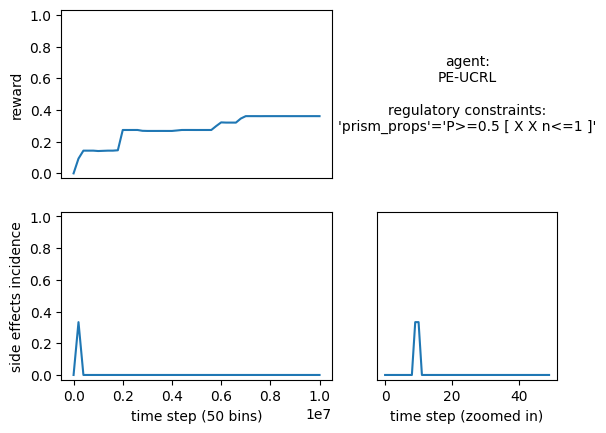

In [17]:
path = 'results/reset_and_deadlock/' + str(14) + '/'
fig = plot_train_summary(path, rmax=1.0)
fig.show()

#### Ablations

/tmp/ipykernel_2723176/3770714969.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2723176/3770714969.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2723176/3770714969.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


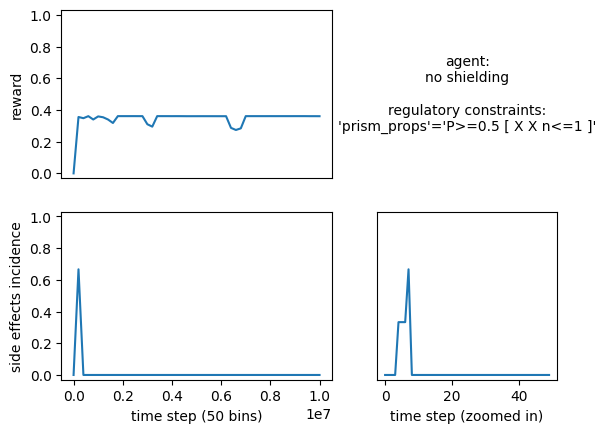

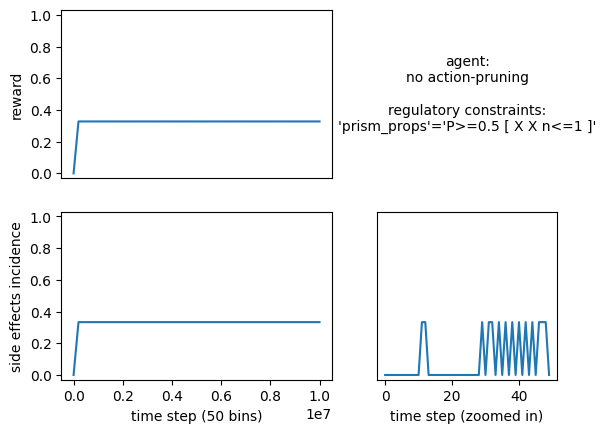

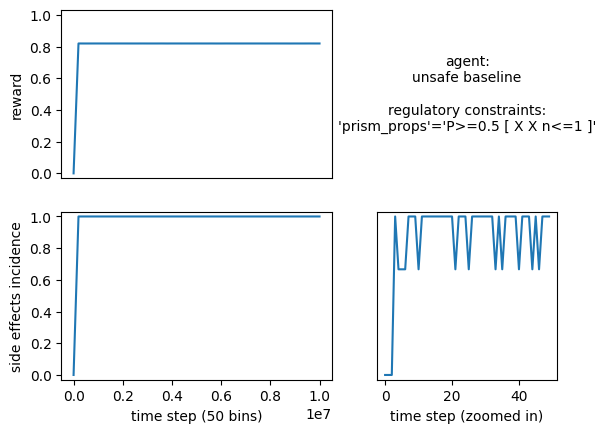

In [18]:
for i in [1, 2, 3]:
    path = 'results/reset_and_deadlock/' + str(i) + '/'
    fig = plot_train_summary(path, rmax=1.0)
    fig.show()

#### SOTA

/tmp/ipykernel_2723176/1871190665.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2723176/1871190665.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2723176/1871190665.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


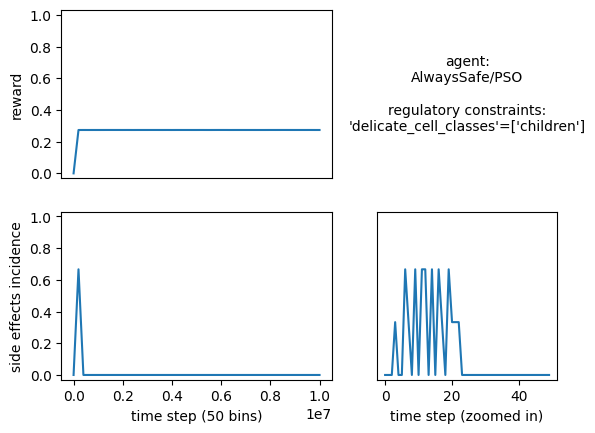

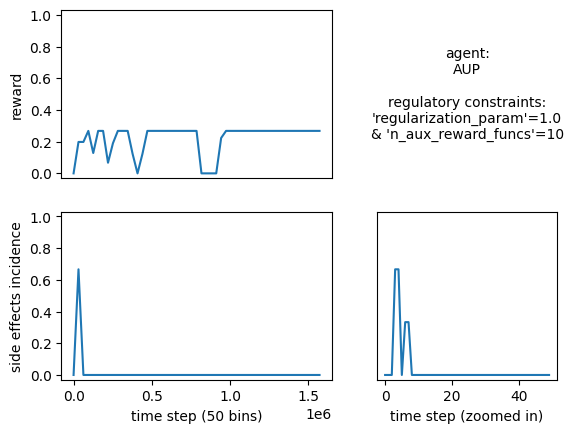

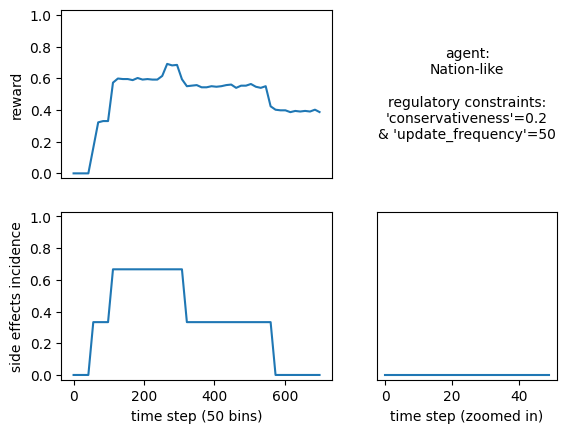

In [19]:
for i in [18, 5, 20]:
    path = 'results/reset_and_deadlock/' + str(i) + '/'
    fig = plot_train_summary(path, rmax=1.0)
    fig.show()

### Deadlock Environment

/tmp/ipykernel_2723176/782359663.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


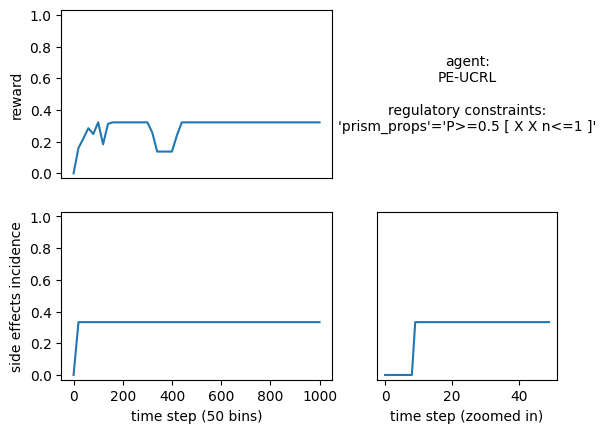

In [21]:
path = 'results/reset_and_deadlock/' + str(7) + '/'
fig = plot_train_summary(path, rmax=1.0)
fig.show()

#### Ablations

/tmp/ipykernel_2723176/1984178792.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2723176/1984178792.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2723176/1984178792.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


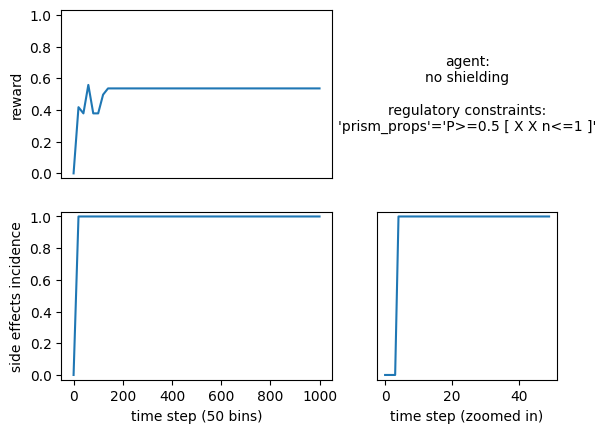

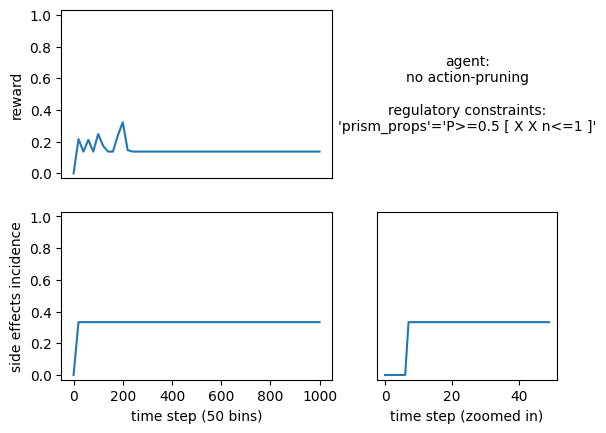

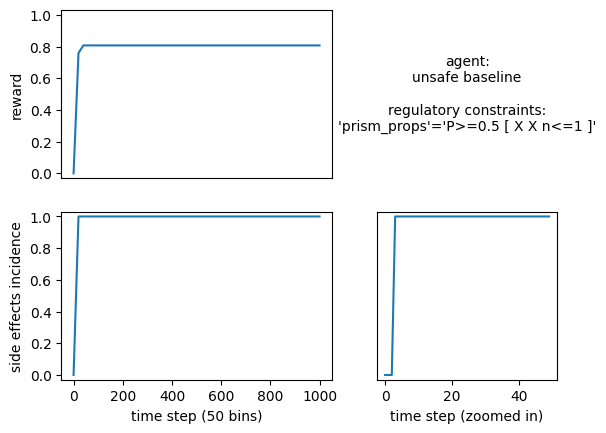

In [23]:
for i in [8, 23, 10]:
    path = 'results/reset_and_deadlock/' + str(i) + '/'
    fig = plot_train_summary(path, rmax=1.0)
    fig.show()

#### SOTA

/tmp/ipykernel_2723176/3516895789.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2723176/3516895789.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2723176/3516895789.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


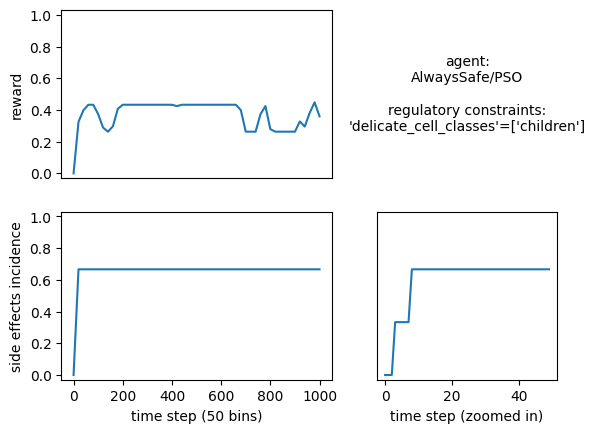

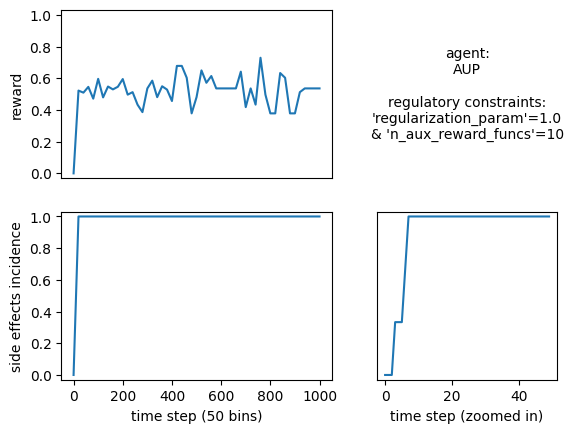

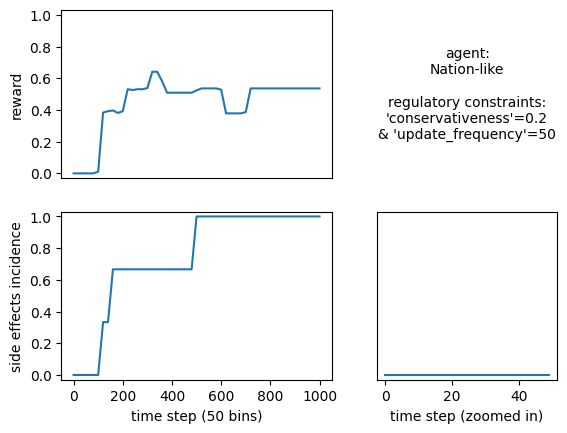

In [24]:
for i in [11, 12, 13]:
    path = 'results/reset_and_deadlock/' + str(i) + '/'
    fig = plot_train_summary(path, rmax=1.0)
    fig.show()

## Discussion

- Our algorithm---*PE-UCRL*---performs well on safety. At all times, it follows the specification in the regulatory constraints. In addition, side effects decrease over time in the *Reset* environment.
- The price for this is slower convergence. Note that it is not lower convergence. In the *Reset* environment, it does eventually reach the safe optimum.
- A weakness is that the design of the *Reset* environment helps with convergence.
  - For the algorithm to update all intracellular policies, it needs to reduce its uncertainty for all relevant transitions.
  - For this to happen, it is (among other things) required to infinitely often visit the initial state.
  - Here, that is enforced by the design of the environment rather than the design of the algorithm.
  - It could be enforced by the design of the algorithm by adding the reward shaping proposed by Moldovan and Abbeel [(Moldovan & Abbeel, 2012, *Safe exploration in Markov decision processes*, ICML)](https://dl.acm.org/doi/abs/10.5555/3042573.3042759), but that is left as future work.

### Ablations

- *No shielding* performs well in the *Reset* envirnment, but it does maximise side effects in the *Deadlock* environment.
- *No action-pruning* satisfies the specification of the regulatory constraints at all times, but side effects incidence increases over time.
- The *unsafe baseline* combines the worst of both worlds.

### SOTA

#### PSO/AlwaysSafe

- *PSO/AlwaysSafe* performs well on safety. Like *PE-UCRL*, it follows the specification in the regulatory constraints at all times, and side effects decrease over time in the *Reset* environment.
- It performs somewhat worse then *PE-UCRL* with respect to reaching the safe optimum. One reason for this is that it always assumes the worst case transition rather than updating them throughout the run. Even if these were to be updated during the run, the constraint that it can never experiment with certain cells means that it still would not have guarantees to reach the safe optimum under the assumptions in the cellular MDP model.

#### AUP

- *AUP* has an uneven performance. In the plots that we have picked, it accumulates reward. However, in some experiments, it behaves as though it completely trades off liveness in favour of safety. In other words, side effects remain at 0 but so does reward.
- At other times, the safety guarantees are very unreliable. In the deadlock environment, it sometimes maximises side effects instead.
  - In the plot shown here, it does not even get a very high reward for doing this. Lower than optimal reward is unsurprising. This particular regularisation function will always distort the reward function for the agent in such a way that the optimal policy for the shaped reward function does not need to coincide with the optimal policy for the unshaped reward function. In other words, *AUP* uses lower convergence rather than slower convergence---in contrast to *PE-UCRL*.
- Sometimes, *AUP* can perform quite well, see the AUP plot for the Reset environment. The maximum side effects incidence is 67% and the accumulated reward approaches the safe optimum. In addition, the side effects decrease over time.
- In conclusion, it is difficult to get reliable performance from *AUP*. That could be imporved with hyperparameter search. (The hyperparameters are specified in the regulatory cosntraints.) However, it is hard to theoretically know how to pick the hyperparameters. In particular, they do not exploit the cellular structure of the cellular MDP in any way. Nor do they exploit any other kind of structure or prior knowledge---unlike *PE-UCRL* or *PSO/AlwaysSafe*.

#### Nation-Like

- *Nation-Like* agents sometimes maximise side effects incidence as shown in the plot for the *Deadlock* environment. In some other experiments, it plateaued at a 67% incidence though.
  - Even when side effects are maximised, the side effects only increase gradually up until that point, which could be seen as a redeeming feature.
  - TODO: It looks as though it only updates according to the update frequency even if an action is pruned. I should check the implementation of this and make the comparison a bit fairer.
- For being a greedy algorithm, it performs surprisingly well with respect to convergence. This may be because of the simplicity of the environments.
  - TODO: Make some more challenging environments.